In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm


c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
def plot_call_put_payoff():
    K = 100
    S = np.linspace(0, 200, 100)
    call_payoff = np.maximum(S - K, 0)
    put_payoff = np.maximum(K - S, 0)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(S, call_payoff, label='Call option')
    axs[0].set_xlabel('Stock price')
    axs[0].set_ylabel('Payoff')
    axs[0].set_title('Payoff of call option with strike price K = 100')
    axs[0].legend()

    axs[1].plot(S, put_payoff, label='Put option', color='orange')
    axs[1].set_xlabel('Stock price')
    axs[1].set_ylabel('Payoff')
    axs[1].set_title('Payoff of put option with strike price K = 100')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_call_put_payoff()



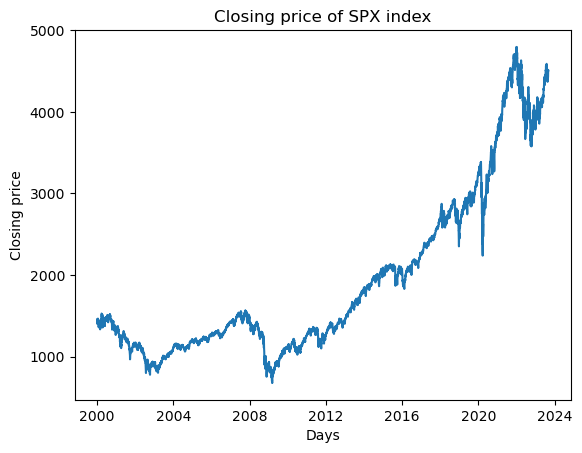

In [2]:

# import csv from desktop into pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('C:/Users/User/Desktop/Data speciale/SPX_indicies_data.csv')
interst_rates = pd.read_csv('C:/Users/User/Desktop/Data speciale/3M_US_yield_data.csv')
df.index = pd.to_datetime(df['date'])

# plot the closing price of the SPX index
plt.plot(df['close'])
plt.xlabel('Days')
plt.ylabel('Closing price')
plt.title('Closing price of SPX index')
plt.show()

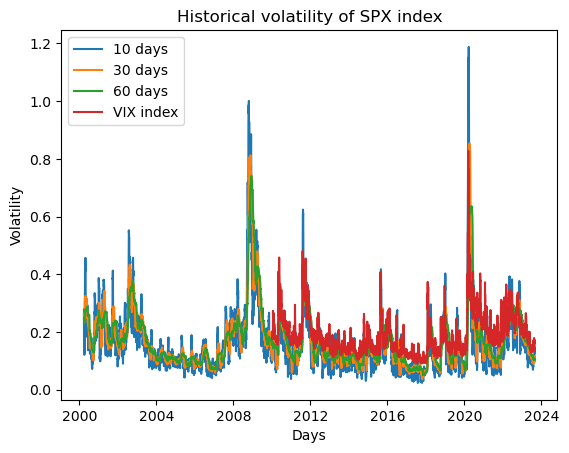

In [3]:

import arch 

# Calculating hisotrical volatility on the SPX index

df = pd.read_csv('C:/Users/User/Desktop/Data speciale/SPX_indicies_data.csv', parse_dates = True, index_col = 'date')
df.index = pd.to_datetime(df.index)

data = pd.DataFrame(df['close'])
data['return'] = data['close'].pct_change()
data.dropna(inplace = True)

# Historical volatility
vol = pd.DataFrame(columns= ['HistVol10', 'HistVol30', 'HistVol60'])
vol['HistVol10'] = data['return'].rolling(window = 10).std() * np.sqrt(252)
vol['HistVol30'] = data['return'].rolling(window = 30).std() * np.sqrt(252)
vol['HistVol60'] = data['return'].rolling(window = 60).std() * np.sqrt(252)
vol.dropna(inplace = True)

# VIX index

vix = pd.read_csv('C:/Users/User/Desktop/Data speciale/VIX_data.csv', parse_dates = True, index_col = 'date')
vix.index = pd.to_datetime(vix.index)
vix = vix[vix.index >= '2010-01-01']
vix = vix[vix.index <= '2023-08-31']
vol['VIX'] = vix['close']/100



# Plotting the historical volatility
plt.plot(vol['HistVol10'], label = '10 days')
plt.plot(vol['HistVol30'], label = '30 days')
plt.plot(vol['HistVol60'], label = '60 days')
plt.plot(vol['VIX'], label = 'VIX index')
plt.xlabel('Days')
plt.ylabel('Volatility')
plt.title('Historical volatility of SPX index')
plt.legend()
plt.show()




In [13]:

options = pd.read_csv('C:/Users/User/Desktop/Data speciale/SPX_options_data.csv')



In [14]:
stock_price = pd.read_csv('C:/Users/User/Desktop/Data speciale/SPX_indicies_data.csv', parse_dates=True, index_col='date')
stock_price = pd.DataFrame(stock_price['close'])
interst_rates = pd.read_csv('C:/Users/User/Desktop/Data speciale/3M_US_yield_data.csv', parse_dates=True, index_col='DATE', na_values='.')
interst_rates = pd.DataFrame(interst_rates['DTB3'])    
interst_rates.dropna(inplace=True)
interst_rates['rate'] = interst_rates['DTB3']/100
del(interst_rates['DTB3'])



In [15]:

# select only the columns we need 


data = options[['date','exdate','strike_price','best_bid','best_offer']]


data['strike_price'] = data['strike_price']/1000
data = data[data['best_bid'] > 0]
data['price'] = (data['best_bid'] + data['best_offer'])/2
data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d') 
data['exdate'] = pd.to_datetime(data['exdate'], format = '%Y-%m-%d')
data['time_to_maturity'] = (data['exdate'] - data['date']).dt.days/365
data = data.set_index('date')
data = data[(data['time_to_maturity'] <= 2)]
data['Year'] = data.index.year
data = data.merge(stock_price, left_index = True, right_index = True, how='left')
data = data.merge(interst_rates, left_index= True, right_index = True, how='left')
data = data.merge(vol, left_index = True, right_index = True, how='left')
data['moneyness'] = data['close']/data['strike_price']
data = data[(data['moneyness'] <= 1.5)]
data = data[(data['moneyness'] >= 0.8)]






C:\Users\User\AppData\Local\Temp\ipykernel_17056\3568806013.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['strike_price'] = data['strike_price']/1000


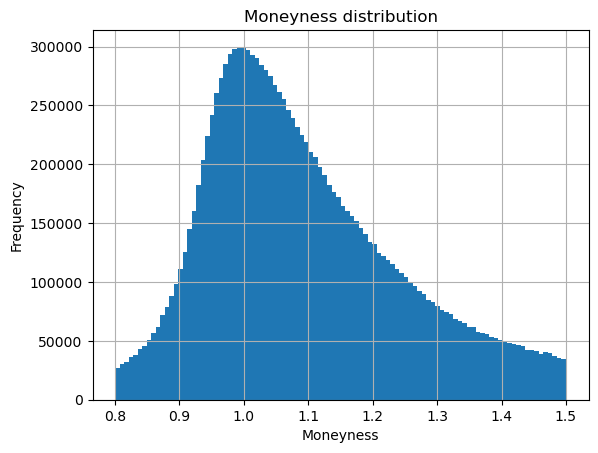

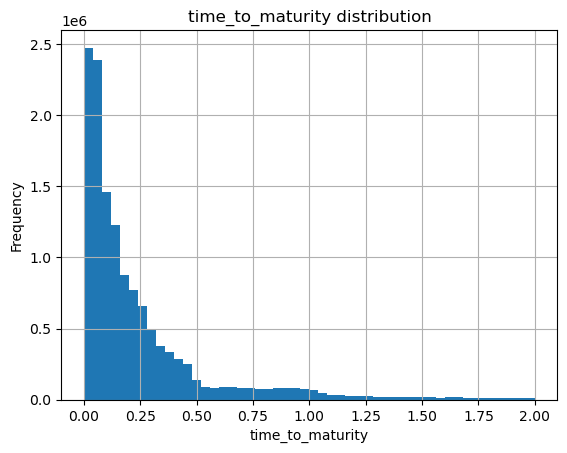

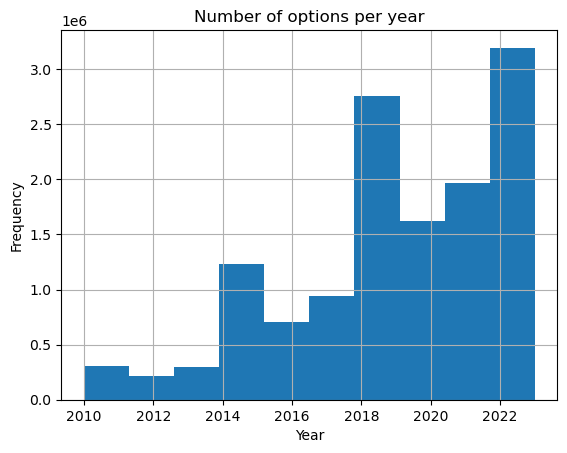

In [16]:
# plot moneyess distribution
data['moneyness'].hist(bins = 100)
plt.xlabel('Moneyness')
plt.ylabel('Frequency')
plt.title('Moneyness distribution')
plt.show()

data['time_to_maturity'].hist(bins = 50)
plt.xlabel('time_to_maturity')
plt.ylabel('Frequency')
plt.title('time_to_maturity distribution')
plt.show()

# plot number of options per year
data['Year'].hist()
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Number of options per year')
plt.show()






In [17]:
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return price



data['BS (vol10)'] = black_scholes(data['close'], data['strike_price'], data['time_to_maturity'], data['rate'], data['HistVol10'], option_type='call')
data['BS (vol30)'] = black_scholes(data['close'], data['strike_price'], data['time_to_maturity'], data['rate'], data['HistVol30'], option_type='call')
data['BS (vol60)'] = black_scholes(data['close'], data['strike_price'], data['time_to_maturity'], data['rate'], data['HistVol60'], option_type='call')
